## Final Project Submission

Please fill out:
* Student name: Julia Müller
* Student pace: self paced 
* Scheduled project review date/time: 28.02.2023
* Instructor name: Mark Barbour
* Blog post URL:

### Setup preparation


In [1]:
# loading basic packages for data manipulation 
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
import math
# loading basic packages for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
# loading basic packages for statistics
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
%cd data

C:\Users\mullerju\Documents\Flatiron\Course_Material\Phase_2\dsc-phase-2-project-v2-5\data


### Data preparation
In this section, the data will be loaded and inspected. I will decide what to do with missing values, duplicates and outliers. I will also see if any variables will have to be scaled and do one-hot-encoding with categorical variables.

In [3]:
df = pd.read_csv("kc_house_data.csv") #read csv
df.info() #inspect and see only few NAs
df.dropna(inplace = True) #drop all rows with nas
df = df.drop_duplicates() #drop duplicate rows
df.drop(["id"], axis = 1, inplace = True) #drop too detailed information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

We have overall more than 30.000 data points with almost no missing values. Therefore, we will drop all the rows where there are missing values. We have several categorical values and numerical values. Later, we will decide if we transform them or not.

In [4]:
#For all variables, I want to see the values distribution
for column in df.columns:
    print(f"Unique values in column '{column}': \n{df[column].unique()}")
    print(f"Values distribution '{column}': \n{df[column].value_counts()}\n")

Unique values in column 'date': 
['5/24/2022' '12/13/2021' '9/29/2021' '12/14/2021' '8/24/2021' '7/20/2021'
 '11/17/2021' '4/28/2022' '3/17/2022' '6/21/2021' '6/1/2022' '6/11/2021'
 '6/25/2021' '11/15/2021' '8/26/2021' '3/28/2022' '6/16/2021' '3/23/2022'
 '3/24/2022' '9/28/2021' '10/19/2021' '2/28/2022' '12/28/2021'
 '11/19/2021' '11/4/2021' '10/8/2021' '5/4/2022' '2/26/2022' '9/7/2021'
 '9/13/2021' '8/18/2021' '8/20/2021' '8/16/2021' '4/11/2022' '11/3/2021'
 '3/2/2022' '6/29/2021' '4/1/2022' '11/20/2021' '8/25/2021' '3/16/2022'
 '7/9/2021' '3/22/2022' '6/14/2021' '11/12/2021' '11/5/2021' '6/23/2021'
 '7/22/2021' '6/2/2022' '5/19/2022' '5/3/2022' '9/10/2021' '2/15/2022'
 '8/31/2021' '4/13/2022' '12/7/2021' '4/19/2022' '5/31/2022' '7/29/2021'
 '6/18/2021' '9/16/2021' '6/20/2021' '10/21/2021' '10/29/2021' '7/21/2021'
 '12/8/2021' '12/11/2021' '12/6/2021' '12/20/2021' '8/2/2021' '1/14/2022'
 '3/7/2022' '11/29/2021' '11/30/2021' '4/2/2022' '5/2/2022' '8/13/2021'
 '9/14/2021' '1/21/2022' '7

There are two findings: there are houses with no bedrooms and houses with 0 or 0.5 bathrooms. We would expect every house to at least have 1 bedroom and at least 1 bathroom with shower or bathtub. 

In [5]:
# I will drop the objects with 0 or 0.5 bathrooms. 
#And I'll round up the bathrooms to have complete bathrooms
df = df[df["bathrooms"] >= 1]
df = df[df["bedrooms"] >= 1]
# rounding bathrooms and bedrooms
df['bathrooms'] = df['bathrooms'].apply(lambda x: math.ceil(x))
df['bedrooms'] = df['bedrooms'].apply(lambda x: math.ceil(x))

In [6]:
#I want to calculate from the two date columns how old the house
#was when it was sold. for this i will subtract
#the date it was built from the date it was sold and
#get a new column with the age.
df["date"] = df["date"].str[-4:].apply(int) #extracting the year
delta = df["date"] - df["yr_built"] #calculating date
df["age"] = delta
#drop too detailed information
df.drop(["date", "yr_built"], axis=1, inplace=True) 

Regarding the location, there seem to be objects outside of King County. I will remove all objects outside King County

In [7]:
# define zip code pattern
zip_code_pattern = r"\b\d{5}(?:-\d{4})?\b"

# create new column with extracted zip codes
df['Zip Code'] = df['address'].apply(
    lambda x: re.search(zip_code_pattern, x).group(
    ) if re.search(zip_code_pattern, x)else None)

url = 'https://www.zipcode.com.ng/2022/12/king-county-zip-codes-wa.html'

# read html table into a list of dataframes
tables = pd.read_html(url)

# extract the first dataframe from the list
zips = tables[1]
# drop unnecessary columns
zips = zips.drop(['State', 'County'], axis=1)
zips.rename(columns={"ZIP Code": "Zip Code"}, inplace=True)
zips["Zip Code"] = zips["Zip Code"].astype(str)
df = pd.merge(df,zips, on="Zip Code", how="left")
#drop all outside of king county
df = df.dropna(subset=["City"])

Let's next look at the price difference per zip code to combine them into categories of inexpensive/expensive neighbourhoods

In [8]:
# calculate the mean price for each zip code
mean_price = df.groupby('Zip Code')['price'].mean()

# create five categories based on the mean price
categories = pd.cut(mean_price, bins=5, labels=[
    'Very low', 'Low', "Medium", "High", "Very High"])

# add the category column to the original dataframe
df['zip_category'] = df['Zip Code'].map(categories)
df['zip_category'] = df['zip_category'].astype(str)


In [9]:
# Create a scatter mapbox figure with the DataFrame
fig = px.scatter_mapbox(df, lat='lat', lon='long',color="zip_category", 
                 color_continuous_scale=px.colors.sequential.Viridis)

# Set the mapbox style
fig.update_layout(mapbox_style='open-street-map')

# Show the figure
fig.show()

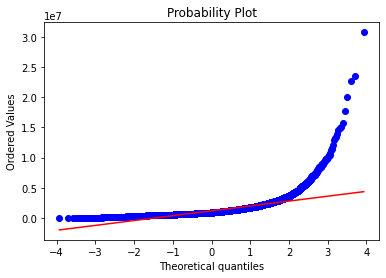

In [10]:
#check distribution of the price
res = stats.probplot(df['price'], plot=plt)

We can see that there are heavy outliers in certain areas on the map and confirmed this with the qq plot. I will try to log transform the price

In [11]:
df["price_log"] = np.log(df["price"]) #log transforming price

In [12]:
from scipy.stats import skew
data_skewness = skew(df["price_log"])
print("Skewness of the data: ", data_skewness)

Skewness of the data:  0.12381872198073594


The skew looks good now.

In [13]:
# recalculate the mean price for each zip code
mean_price = df.groupby('Zip Code')['price_log'].mean()

# create four categories based on the mean price
categories = pd.cut(mean_price, bins=5, labels=[
    'Very low', 'Low', "Medium", "High", "Very High"])

# add the category column to the original dataframe
df['zip_category'] = df['Zip Code'].map(categories)
df['zip_category'] = df['zip_category'].astype(str)
df.drop(["Zip Code"], axis=1, inplace=True) #drop too detailed information)

In [14]:
# Create a scatter mapbox figure with the DataFrame
fig = px.scatter_mapbox(df, lat='lat', lon='long',color="zip_category", 
                 color_continuous_scale=px.colors.sequential.Viridis)

# Set the mapbox style
fig.update_layout(mapbox_style='open-street-map')

# Show the figure
fig.show()

Looking at the map, we can see the distribution of zip codes depending on the average price per zip code. It looks like the south of King County has low house prices. It's surprising that many neighbourhoods close to the water have low house prices. 

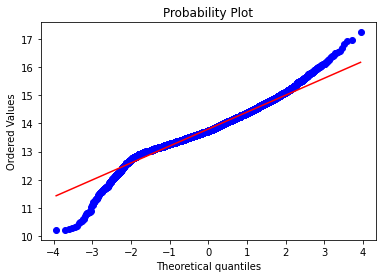

In [15]:
#looking again at distribution
res = stats.probplot(df['price_log'], plot=plt)

Still has quite some outliers. I will try to remove them with the IQR.

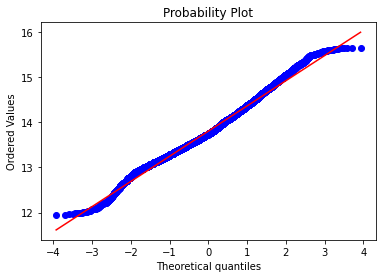

In [16]:
# Compute the IQR
q1, q3 = np.percentile(df["price_log"], [25, 75])
iqr = q3 - q1

# Set the bounds for outlier detection
lower_bound = q1 - 2*iqr
upper_bound = q3 + 2*iqr

# Drop the outliers
df = df[(df["price_log"] >= lower_bound) & (df["price_log"] <= upper_bound)]
res = stats.probplot(df['price_log'], plot=plt)   

In [17]:
#sqft log has a lot of outliers. 
#The information seems unreliable so I will drop the column
df.drop(["sqft_lot"], axis=1, inplace=True) #drop sqft lot
#Also, I will transform the price and sqft_living
#to a logarithm to work against outliers
df["sqft_living_log"] = np.log(df["sqft_living"])
df["sqft_above_log"] = np.log(df["sqft_above"])

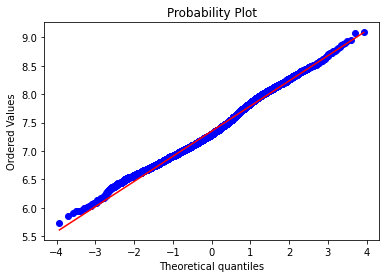

In [18]:
#checking distribution of sqft above log
res = stats.probplot(df['sqft_above_log'], plot=plt)

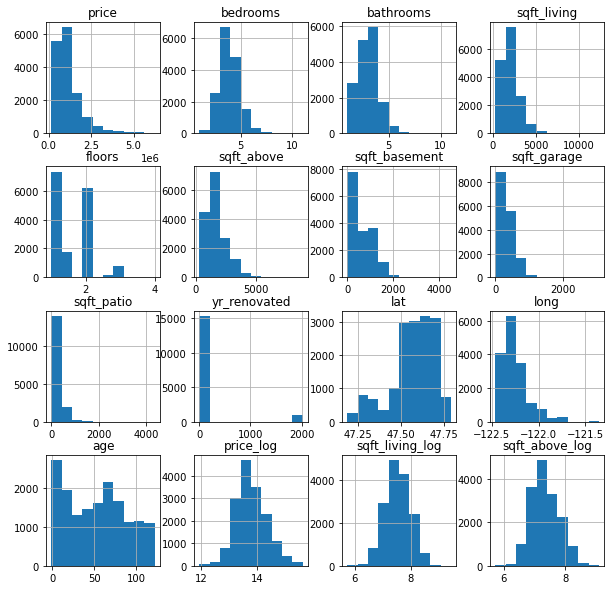

In [19]:
df.hist(figsize=(10,10)) #looking at histogram of variables
plt.show();

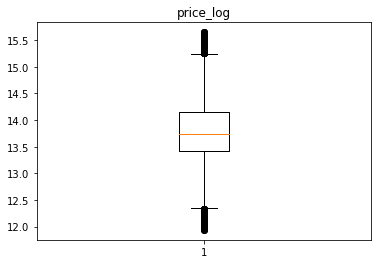

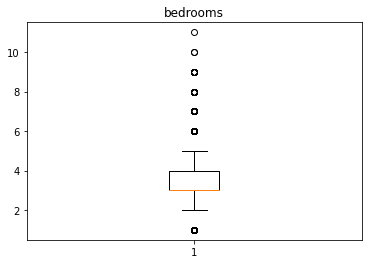

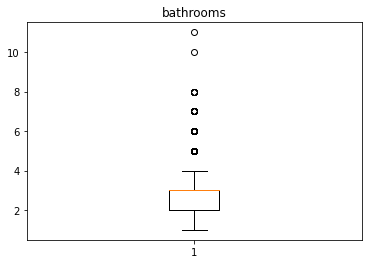

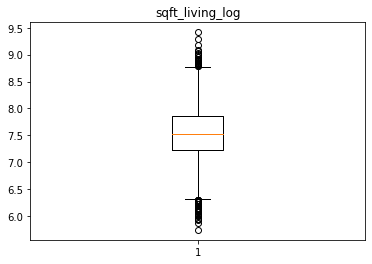

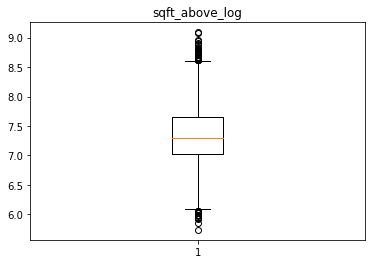

In [20]:
# Check continuous predictors for outliers using Boxplot 

outliers = [
    "price_log",'bedrooms', 'bathrooms', "sqft_living_log",'sqft_above_log']

for outlier in outliers:
    plt.boxplot(df[outlier])
    plt.title(outlier)
    plt.show()

#### Interpretation of the Histograms:
The price is normally distributed after log transforming it.
For the bedrooms, houses have between 1 and 10 bedrooms while the majority have 3.
For the bathrooms, houses have between 1 and 6 bathrooms while the majority have 2.
For sqft living, we had a slight positive skew. After log transforming it, it looks better.
Floors is shown in 0.5 steps, the majority have either 1 or 2 floors.
waterfront only has few yes.
greenbelt only has few yes.
nuisance only has few yes.
the view is mostly None.
the condition is mostly average.
the grade as well.
the most common heat source is gas.
the sewer system is either public or private.
sqft above and sqft basement are positively skewed.
sqft garage and patio have outliers that may have to be removed.
year built starts in 1900 and has its peak in 2020.
year renovates seems to have a lot of missing values which we will have to remove.



For Waterfront, greentbelt, nuisance, view, condition, grade, heat source and sewer system, we can create categorical dummy variables. Looking at the values distribution and the most common values, an average house would consist of the following attributes: 

Waterfront: no
Greenbelt: no
Nuisance: no
View: None
Condition: Average
Grade: Avaerage
Heat source: Gas
Sewer System: Public

I will change the grade of the house and the condition to a numerical column. Also, I will summarize small categories from the variables heat source and sewer system. I will also create categorical columns for objects if they have a basement, garage and patio

The log transformation for the price and sqft living helped. The log price and sqft living is now normally distributed so we can remove the old price indication. 

In [21]:
# I will make a categorical column out of the garage, basement, patio and year renovated
# define a custom function that maps the values to 'yes' or 'no'
def map_to_category(value):
    if value > 0:
        return 'YES'
    else:
        return 'NO'

# apply the function
df['garage'] = df['sqft_garage'].apply(map_to_category)
df['basement'] = df['sqft_basement'].apply(map_to_category)
df['patio'] = df['sqft_patio'].apply(map_to_category)
df['renovated'] = df['yr_renovated'].apply(map_to_category)
#also I will make a numeric variable out of the grade, condition and remap some 
df['grade'] = df['grade'].str.split().str[0].astype(int) 
df["condition"] = df["condition"].replace(
    {'Good': 4, 'Average': 3, 'Very Good': 5, 'Fair': 2, 'Poor': 1})
df["heat_source"] = df["heat_source"].replace(
    {'Gas/Solar': "Other", "Electricity/Solar": "Other", "Oil/Solar": "Other"})
df["sewer_system"] = df["sewer_system"].replace(
    {'PRIVATE RESTRICTED': "PRIVATE", "PUBLIC RESTRICTED": "PUBLIC"})
df = df.drop([
    "lat", "long", "address",'sqft_garage','sqft_basement', 
    "sqft_living","sqft_above",'sqft_patio','yr_renovated'], axis=1)

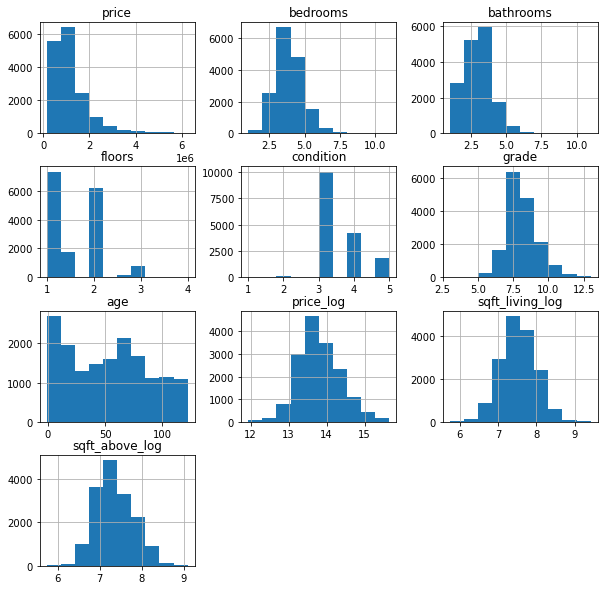

In [22]:
#showing a histogram of numeric columns
df.hist(figsize=(10,10))
plt.show();

Based on the histogram, I will further remove floors from the model, condition and age as it's not normally distributed.

### Feature selection & One hot encoding
In this section, I'm looking at which features to include in the regression model. I will create dummy variables for the categorical columns so that we can evaluate if we include them in the linear regression model. 

In [23]:
y = df["price_log"] #my dependent variable is the log price
#my independent variables are the following
X = df.drop(["price_log", "price",  "City"], axis=1)
#next, I will create dummy variables for the categorical variables
X = pd.get_dummies(X, columns=[
    "waterfront", "basement", "garage", "patio","greenbelt", 
    "nuisance","view", "heat_source", "sewer_system",
    "renovated", "zip_category"], drop_first=False)
#finally, I will drop irrelevant columns
X = X.drop([
    "waterfront_NO", "greenbelt_NO","patio_NO",
    "garage_NO","nuisance_NO","basement_NO", "view_NONE","heat_source_Gas",
    "sewer_system_PUBLIC", "renovated_NO", "zip_category_Medium"], axis=1)

In [24]:
#I want to look at the correlation matrix first
corrmat = pd.concat([y,X], axis=1)
corrmat.corr()["price_log"]

price_log                  1.000000
bedrooms                   0.392566
bathrooms                  0.532535
floors                     0.229950
condition                  0.039605
grade                      0.642347
age                       -0.100998
sqft_living_log            0.646227
sqft_above_log             0.576039
waterfront_YES             0.127733
basement_YES               0.161561
garage_YES                 0.180585
patio_YES                  0.208180
greenbelt_YES              0.099136
nuisance_YES               0.009483
view_AVERAGE               0.131677
view_EXCELLENT             0.199011
view_FAIR                  0.072661
view_GOOD                  0.156557
heat_source_Electricity   -0.167931
heat_source_Oil           -0.082453
heat_source_Other          0.017766
sewer_system_PRIVATE      -0.037957
renovated_YES              0.093616
zip_category_High          0.354898
zip_category_Low          -0.092235
zip_category_Very High     0.254201
zip_category_Very low     -0

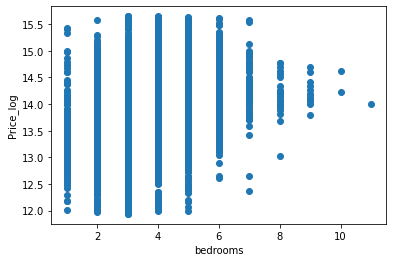

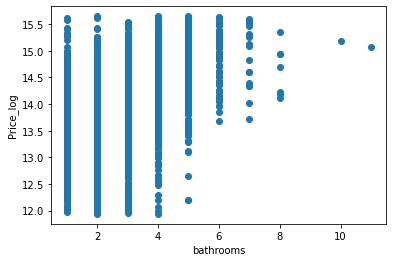

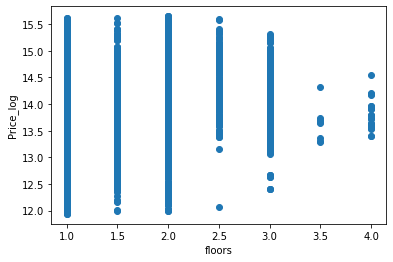

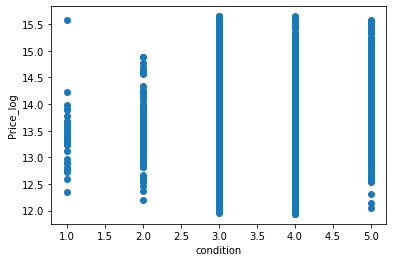

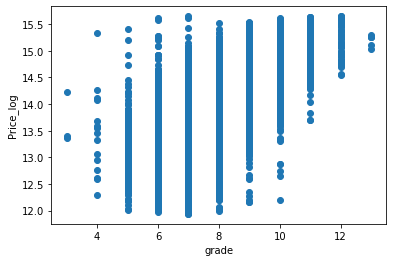

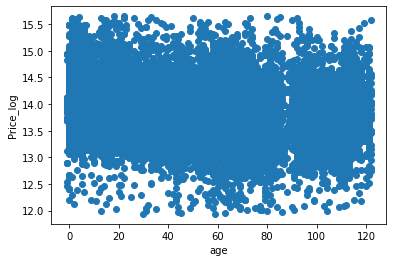

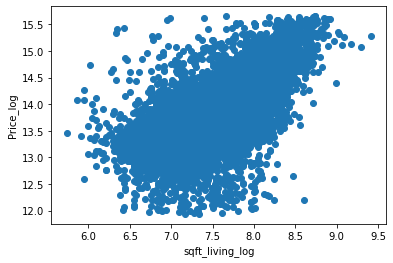

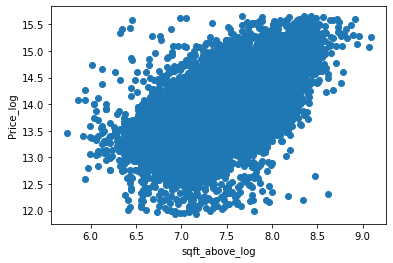

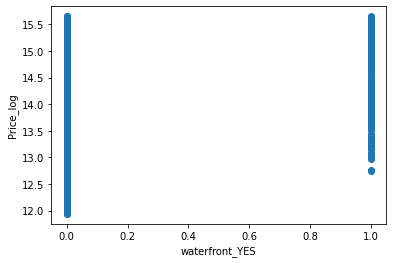

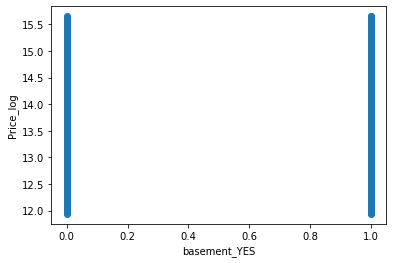

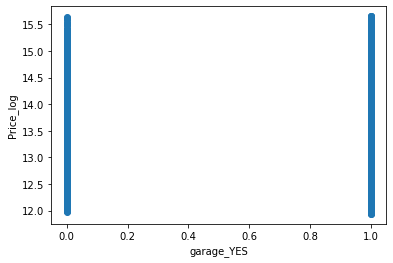

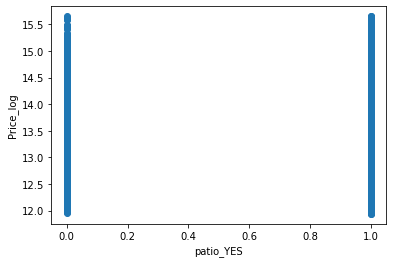

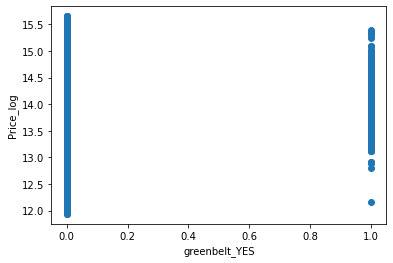

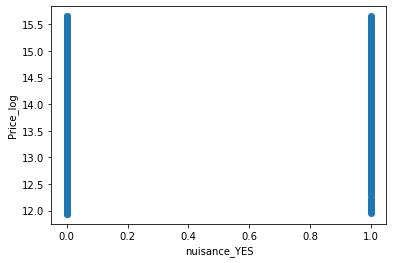

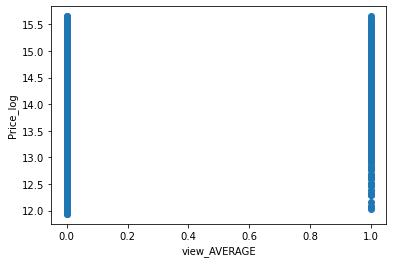

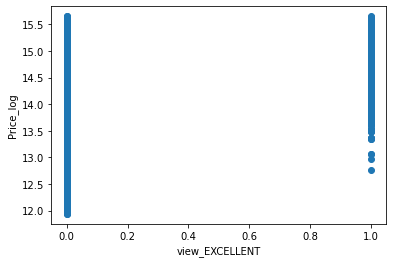

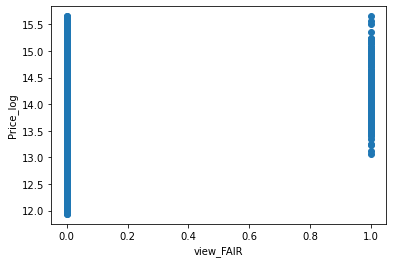

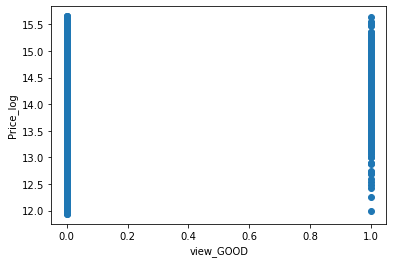

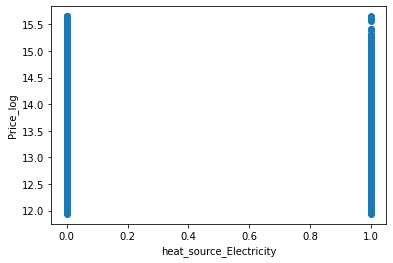

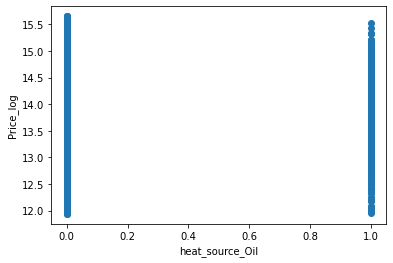

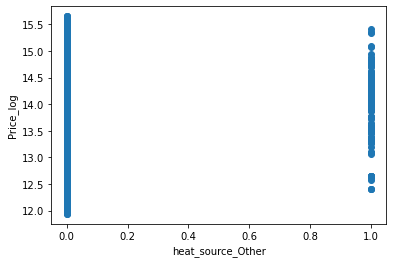

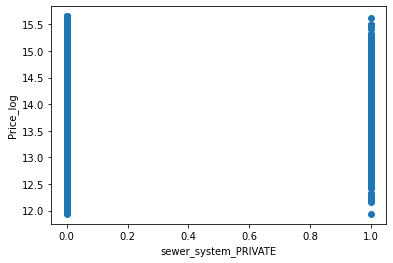

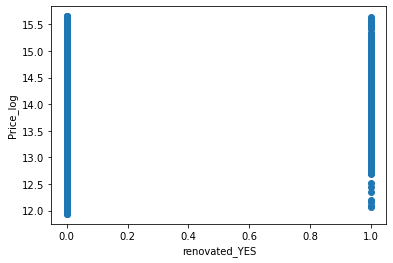

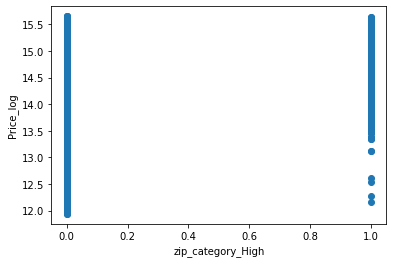

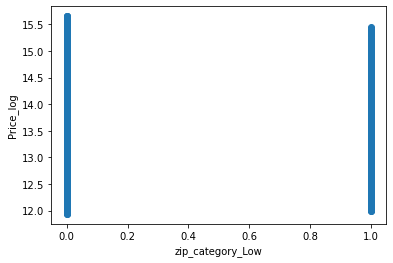

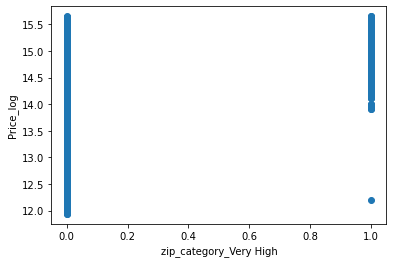

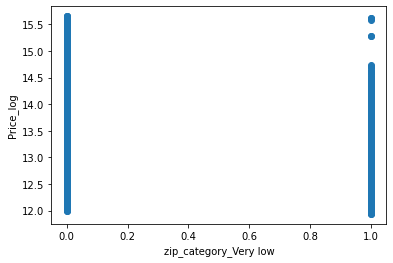

In [25]:
#and at the scatter plots
for col in X.columns:
    plt.scatter(X[col], y)
    plt.xlabel(col)
    plt.ylabel("Price_log")
    plt.show()

There are some high correlations in the correlation matrix. Sqft Living and sqft above seem to be a good indicator and the grade of the construction. I will exclude nuisance and condition from the model due to the low correlations with price log. I will also drop age from the model due to the scatter plot. Before, I will check for multicollinearity

In [26]:
#checking for multicollinearity
cormat=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
cormat['pairs'] = list(zip(cormat.level_0, cormat.level_1))
# set index to pairs
cormat.set_index(['pairs'], inplace = True)
#d rop level columns
cormat.drop(columns=['level_1', 'level_0'], inplace = True)
# rename correlation column as cc rather than 0
cormat.columns = ['cc']
# drop duplicates. 
cormat.drop_duplicates(inplace=True)
cormat[(cormat.cc>.75) & (cormat.cc <1)]

cc
pairs                                      
(sqft_above_log, sqft_living_log)  0.868738
(sqft_living_log, bathrooms)       0.759589

Besides dropping age, condition, nuisance and floors due to their scatter plot or correlation values, I will also drop the sqft_living column due to high correlation with sqft above and the number of bathrooms. 

In [27]:
#dropping variables
X = X.drop(["sqft_living_log","condition","nuisance_YES","age","floors"], axis=1)

In [28]:
#creating the first model
model_base = sm.OLS(y, sm.add_constant(X))
results_base = model_base.fit()
print(results_base.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1722.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:01:41   Log-Likelihood:                -3820.2
No. Observations:               16207   AIC:                             7686.
Df Residuals:                   16184   BIC:                             7863.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Interpretation of the baseline model
The model explains around 70% of the variance and is significant. If all features are 0, the house would sell for around 22000 USD (exp(10). Some variables are not significant (garage, renovated, sewer system, heat source). 
### Improvement of the model
Next, I will improve the model by dropping variables that are not significant or that do not make sense based on the coefficient or based on the scatter plot.

In [29]:
X2 = X.drop(["patio_YES"], axis=1) #dropping patio due non signifcance
model_v2 = sm.OLS(y, sm.add_constant(X2))
results_v2 = model_v2.fit()
print(results_v2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1804.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:01:41   Log-Likelihood:                -3820.3
No. Observations:               16207   AIC:                             7685.
Df Residuals:                   16185   BIC:                             7854.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

I will drop some more variables due to their insignificance

In [30]:
X3 = X2.drop(["heat_source_Electricity",
              "heat_source_Oil", "heat_source_Other"],
             axis=1) #dropping heat sources
model_v3 = sm.OLS(y, sm.add_constant(X3))
results_v3 = model_v3.fit()
print(results_v3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2102.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:01:41   Log-Likelihood:                -3829.0
No. Observations:               16207   AIC:                             7696.
Df Residuals:                   16188   BIC:                             7842.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

In [31]:
#dropping greenbelt because of negative coefficient
X4 = X3.drop(["greenbelt_YES"], axis=1) 
model_v4 = sm.OLS(y, sm.add_constant(X4))
results_v4 = model_v4.fit()
print(results_v4.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2224.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:01:41   Log-Likelihood:                -3834.4
No. Observations:               16207   AIC:                             7705.
Df Residuals:                   16189   BIC:                             7843.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

In [32]:
#finally also dropping the renovated column
X5 = X4.drop(["sewer_system_PRIVATE"], axis=1) #dropping sqft_living due to high correlation with sqft_living and bathrooms
model_v5 = sm.OLS(y, sm.add_constant(X5))
results_v5 = model_v5.fit()
print(results_v5.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2359.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:01:41   Log-Likelihood:                -3843.6
No. Observations:               16207   AIC:                             7721.
Df Residuals:                   16190   BIC:                             7852.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

Looking at the coefficients, the garage coefficient does not make sense. Why should a house with a garage be lower in price than a house without one. Zip categories look good. Bathrooms and bedrooms don't have a lot of impact. I might drop them to avoid overfitting. 

In [33]:
#dropping garage, view, bathroom and bedrooms
X6 = X5.drop(["garage_YES","bathrooms","bedrooms",
              "view_AVERAGE", "view_EXCELLENT", "view_FAIR",
              "view_GOOD"], axis=1) 
model_v6 = sm.OLS(y, sm.add_constant(X6))
results_v6 = model_v6.fit()
print(results_v6.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     3947.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:01:41   Log-Likelihood:                -4186.7
No. Observations:               16207   AIC:                             8393.
Df Residuals:                   16197   BIC:                             8470.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

### Interpretation of my model
Dropping the variables resulted in a slightly lower explained variance but at least all variables are significant and meaningful. The model explains around 68% of the variance and is significant. 
My target variable is in log dollars so if all features are 0, the house would sell for around 22000 USD (exp(10)). For my categorical values, my reference values are: zip_category medium, basement no, waterfront no. 
For the most impactful numerical values, we can say that with each grade increase, the price will increase by 11%. Also, for 10% increase in sqft above, the price will increase by 4%.

The location of a property depending on the zip code also has an impact on price. Compared to zip codes with medium average house prices, the prices drop significantly for low and very low zip code categories and rise significantly for high and higher zip codes. This fits to what we have seen in the zip code map where there are significant differences based on the region. 

In [34]:
#calculating grade increase
print("For each grade increase, price increases by ",
      np.exp(10.0961+0.1083)/np.exp(10.0961))
print("For 10% increase in sqft, price increases by ",
      1.1**0.4044)
print("For waterfront house, geom mean of price increases by ",
      np.exp(10.0961+0.4044)/np.exp(10.0961))
print("For house w basement, geom mean of price increases by ",
      np.exp(10.0961+0.1893)/np.exp(10.0961))
print("For house w renovation, geom mean of price increases by ",
      np.exp(10.0961+0.0985)/np.exp(10.0961))
print("For house w zip category very low compared to medium, geom mean of price decreases by ",
      np.exp(10.0961-0.6086)/np.exp(10.0961))
print("For house w zip category  low compared to medium, geom mean of price decreases by ",
      np.exp(10.0961-0.2222)/np.exp(10.0961))
print("For house w zip category high compared to medium, geom mean of price increases by ",
      np.exp(10.0961+0.2230)/np.exp(10.0961))
print("For house w zip category very high compared to medium, geom mean of price increases by ",
      np.exp(10.0961+0.5922)/np.exp(10.0961))

For each grade increase, price increases by  1.1143820098472454
For 10% increase in sqft, price increases by  1.0392958709738869
For waterfront house, geom mean of price increases by  1.498403188377217
For house w basement, geom mean of price increases by  1.2084034191359254
For house w renovation, geom mean of price increases by  1.103514404394391
For house w zip category very low compared to medium, geom mean of price decreases by  0.5441120930236357
For house w zip category  low compared to medium, geom mean of price decreases by  0.8007551972790311
For house w zip category high compared to medium, geom mean of price increases by  1.2498205737359849
For house w zip category very high compared to medium, geom mean of price increases by  1.8079615587669373


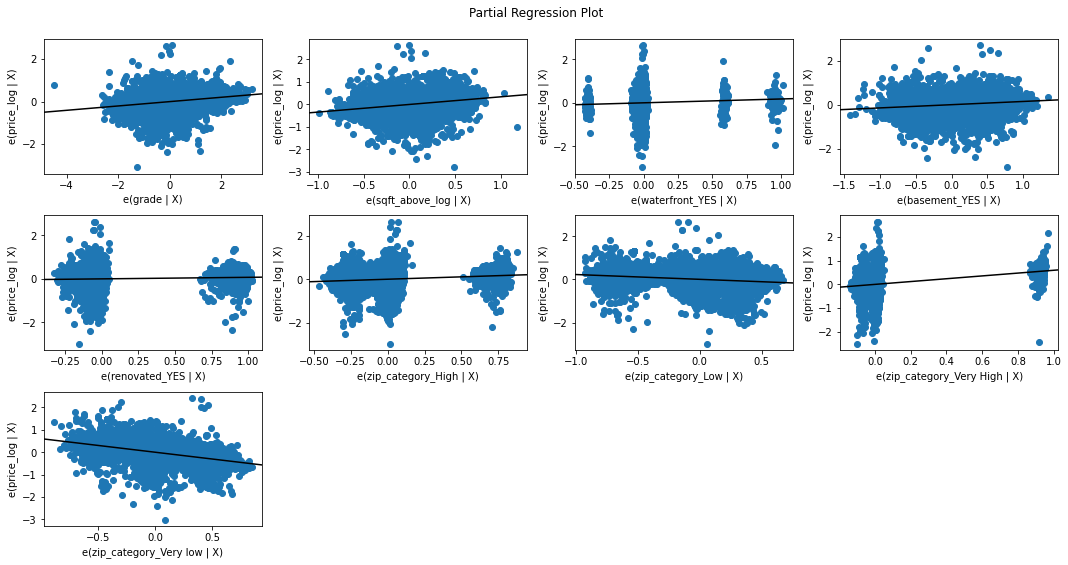

In [35]:
#inspecting the residuals
fig = plt.figure(figsize=(15,15))
sm.graphics.plot_partregress_grid(
    results_v5,
    exog_idx=list(X6.columns.values),
    grid=(6,4),
    fig=fig)
plt.show()

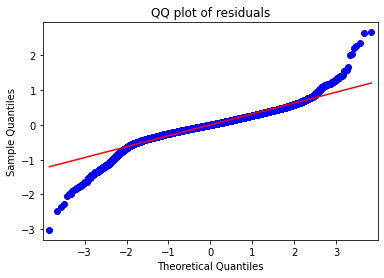

In [36]:
residuals = results_v6.resid
sm.qqplot(residuals, line="s")
plt.title("QQ plot of residuals")
plt.show()

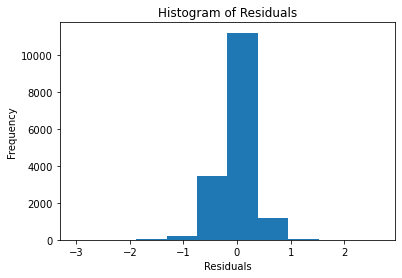

In [37]:
plt.hist(residuals, bins=10)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [38]:
from scipy.stats import shapiro
# Perform the Shapiro-Wilk test on residuals
stat, p = shapiro(residuals)
print('Shapiro-Wilk test statistic: {:.3f}, p-value: {:.3f}'.format(stat, p))
if p > 0.05:
    print('Residuals are normally distributed')
else:
    print('Residuals are not normally distributed')

Shapiro-Wilk test statistic: 0.941, p-value: 0.000
Residuals are not normally distributed


C:\Users\mullerju\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



My residuals are not normally distributed. Looking at a confidence interval, my model is great at predicting values within 2 standard deviations of the mean so for 95% of the objects, the model will work well. For anything outside of this range it will underestimate the price of expensive objects and overestimate the price of cheap houses.

### Calculating the MAE
The MAE is more appropriate for models with a log-transformed dependent variable because it measures the absolute difference between the predicted and actual values on the original scale of the data.
When both the dependent and independent variables are log-transformed, the Mean Absolute Error (MAE) can be interpreted as the average absolute difference between the actual and predicted values, expressed as a percentage of the geometric mean of the actual and predicted values.

The geometric mean is used because the log transformation converts multiplication to addition, so the geometric mean of the actual and predicted values is the exponential of the mean of the log-transformed values.

In [39]:
model = LinearRegression()
model.fit(X6,y)
yhat = model.predict(X6)

In [40]:
# use the scikit-learn library's mean_absolute_error function
mae = mean_absolute_error(np.exp(y), np.exp(yhat))
geom_mean = np.sqrt(np.exp(y) * np.exp(yhat))
mae_percent = mae / np.mean(geom_mean) * 100

print("MAE (as percentage of geometric mean): {:.2f}%".format(mae_percent))

MAE (as percentage of geometric mean): 23.04%


In [41]:
# use the scikit-learn library's mean_absolute_error function
mae = mean_absolute_error(np.exp(y), np.exp(yhat))
geom_mean = np.sqrt(np.exp(y) * np.exp(yhat))
mae_percent = mae / np.mean(geom_mean) * 100

print("MAE (as percentage of geometric mean): {:.2f}%".format(mae_percent))

MAE (as percentage of geometric mean): 23.04%


On average, my model's prediction is off by 23% of the geometric mean of the actual and predicted values. This should be improved with future models.

### Further testing
I will now again look at the boxplots of the categorical values and confirm with a ttest or ANOVA

Testing Hypothesis 1: 
H1: The price is different depending on the neighbourhood you live in. 
H0: There is no difference depending on where you live.

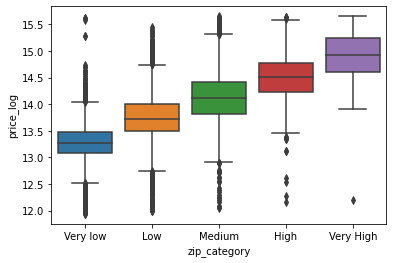

In [42]:
#Visualising with a box plot
sns.boxplot( x=df["zip_category"], y=df["price_log"], order=[
    "Very low", "Low", "Medium", "High", "Very High"] );
plt.show()

In [43]:
#preparing the groups for my ANOVA
Very_low = df[df["zip_category"]=="Very low"]["price_log"]
Low = df[df["zip_category"]=="Low"]["price_log"]
Medium = df[df["zip_category"]=="Medium"]["price_log"]
High = df[df["zip_category"]=="High"]["price_log"]
Very_high = df[df["zip_category"]=="Very High"]["price_log"]

In [44]:
#Conducting ANOVA
from scipy.stats import f_oneway
f_oneway(Very_low, Low, Medium, High, Very_high)
print("Mean very low: ", Very_low.mean())
print("Mean very high: ", Very_high.mean())

Mean very low:  13.278613131321137
Mean very high:  14.894837664514732


ANOVA shows that there is indeed a price difference depending on the neighbourhood you are in. Therefore, rejecting the null hypothesis. The prices vary from a mean  of 580.0000 USD in the very low zipcodes and 2.9 mio USD in the very high zipcodes

Testing Hypothesis 2: The price of a house is higher if you have a waterfront
H0: The price is less or equal when you have a waterfront

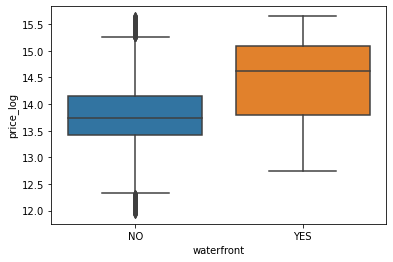

In [45]:
#visualising with boxplot
sns.boxplot( x=df["waterfront"], y=df["price_log"] );
plt.show()

In [46]:
#conducting t.test
from scipy.stats import ttest_ind
waterfront = df[df["waterfront"]=="YES"]["price_log"]
no_waterfront = df[df["waterfront"]=="NO"]["price_log"]
t_stat, p_value = ttest_ind(waterfront, no_waterfront)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)
print("Mean No waterfront: ", no_waterfront.mean())
print("Mean waterfront: ", waterfront.mean())

T-statistic value:  16.394556349400133
P-Value:  6.350296717606978e-60
Mean No waterfront:  13.79572730987044
Mean waterfront:  14.458361520828648


Rejecting the null hypothesis. If you have no waterfront, the mean price is exp(13.79) which are 974000 USD. If you have a waterfront, the mean price is exp(14.45) which is 1.88 Mio USD. In the boxplot you can see, that even with no waterfront, you have a lot of outliers on both sides.

Testing Hypothesis 3: The price of a house is higher if you have a basement H0: The price is less or equal when you have a basement

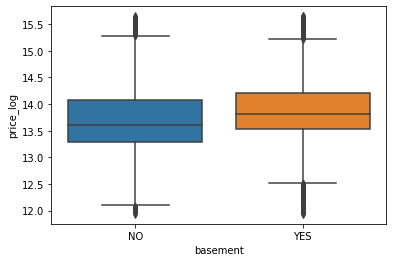

In [47]:
#visualising with boxplot
sns.boxplot( x=df["basement"], y=df["price_log"] );
plt.show()

In [48]:
#conducting t-test
basement = df[df["basement"]=="YES"]["price_log"]
no_basement = df[df["basement"]=="NO"]["price_log"]
t_stat, p_value = ttest_ind(basement, no_basement)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)
print("Mean No basement: ", no_basement.mean())
print("Mean basement: ", basement.mean())

T-statistic value:  20.84027400630386
P-Value:  3.301642077452239e-95
Mean No basement:  13.696640588525463
Mean basement:  13.88006691220265


Rejecting the null hypothesis. If you have no basement, the mean price is exp(13.69) which are 882000 USD. If you have a basement, the mean price is exp(13.88) which is 1.06 Mio USD. Compared to the waterfront, the price difference is not that large which makes sense.

Testing Hypothesis 4: The price of a house is higher if you have renovated H0: The price is less or equal when you have renovated

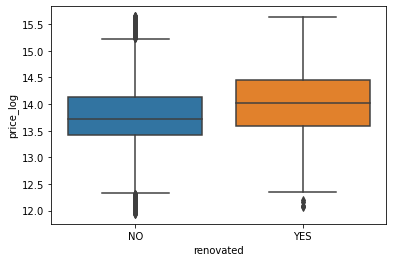

In [49]:
#visualising with boxplot
sns.boxplot( x=df["renovated"], y=df["price_log"] );
plt.show()

In [50]:
#conducting t-test
renovated = df[df["renovated"]=="YES"]["price_log"]
no_renovated = df[df["renovated"]=="NO"]["price_log"]
t_stat, p_value = ttest_ind(renovated, no_renovated)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)
print("Mean No renovated: ", no_renovated.mean())
print("Mean renovated: ", renovated.mean())

T-statistic value:  11.969789579744424
P-Value:  7.039674909192125e-33
Mean No renovated:  13.790768445808618
Mean renovated:  14.018666512045364


Rejecting the null hypothesis. If you have not renovated, the mean price is exp(13.79) which are 974000 USD. If you have renovated, the mean price is exp(14.01) which is 1.2 Mio USD. 

## Summary
The model is a good start but requires further improving. We could look next at some other variables which might have an influence on the price. In general, it is understandable that you are not able to predict all house prices. There will always be exceptions so my model which is between 2 standard deviations predicts actually quite well.